## Data generation and analysis

This notebook analyzes the data used for training the models.

### Tree generation and splitting

Synthetic trees describe the chemical synthesis of one molecule. These data are key because they are fed to the model, determining its accuracy. First, we download the filtered synthetic trees sets. These files contain around 450000 synthetic trees that have been generated using script 03 (03-generate-synthetic trees) and filtered using script 04 (04-filter-trees) to obtain trees containing drug-like molecule roots.

In [1]:
import gzip
import json
import random    
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
from downloader import get_filtered_syntrees
from pathlib import Path

path = 'training_data/'

get_filtered_syntrees(path)

/home/sabanza/miniconda3/envs/synnet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
13:14:56 rdkit INFO: Enabling RDKit 2021.03.5 jupyter extensions


train.json.gz already exists. But 'force' is set, bypassing...


validation.json.gz already exists. But 'force' is set, bypassing...


test.json.gz already exists. But 'force' is set, bypassing...


Load each set and check number of trees contained.

In [2]:
#Train trees 
with gzip.open("training_data/train.json.gz", "rb") as f:
    train = json.loads(f.read())['trees']

#Validation trees
with gzip.open("training_data/validation.json.gz", "rb") as f:
    valid = json.loads(f.read())['trees']

#Test trees
with gzip.open("training_data/test.json.gz", "rb") as f:
    test = json.loads(f.read())['trees']


names = ['train', 'validation', 'test']

for name, trees in zip(names, (train, valid, test)):
    print('{0} set contains {1} trees'.format(name, len(trees)))

train set contains 269322 trees
validation set contains 89774 trees
test set contains 89775 trees


A synthetic tree is formed by a dictionary containing different keys: reactions, chemicals, depth, actions and rxn_id2type. By analyzing feature distribution on each tree set, we can check if all sets have the same data distribution.

In [69]:
#Check one tree structure
print(train[0])

{'reactions': [{'rxn_id': 38, 'rtype': 2, 'parent': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'child': ['COc1ccc(O)c(C(C)N)c1', 'COc1ccc(C=C(C)S(=O)(=O)Cl)cc1'], 'depth': 0.5, 'index': 0}], 'chemicals': [{'smiles': 'COc1ccc(O)c(C(C)N)c1', 'parent': 38, 'child': None, 'is_leaf': True, 'is_root': False, 'depth': 0, 'index': 0}, {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)Cl)cc1', 'parent': 38, 'child': None, 'is_leaf': True, 'is_root': False, 'depth': 0, 'index': 1}, {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'parent': None, 'child': 38, 'is_leaf': False, 'is_root': True, 'depth': 1, 'index': 2}], 'root': {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'parent': None, 'child': 38, 'is_leaf': False, 'is_root': True, 'depth': 1, 'index': 2}, 'depth': 1, 'actions': [0, 3], 'rxn_id2type': None}


### Data distribution

We check tree depth distribution for each set. Tree depth determines the complexity of the synthesis (the more steps a synthesis has, the more challenging it is). Therefore, we would like to know how the different synthesis are distributed and their complexity distribution.

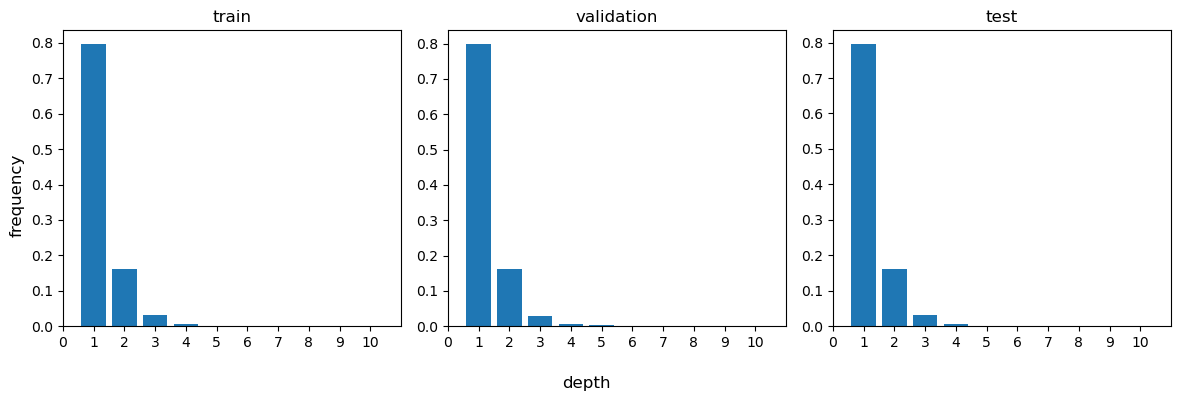

In [13]:
#Plot tree depth frequency for each set 
fig, ax = plt.subplots(1,3, sharey = False, figsize=(12,4))

for i, trees in enumerate([train, valid, test]):
    depth = [int(tree['depth']) for tree in trees]
    depth = pd.Series(depth)
    counts = depth.value_counts(normalize=True)
    ind = counts.index
    freq = counts.values
    ax[i].bar(ind, freq)
    ax[i].set_xlim((0,11))
    ax[i].set_xticks(list(range(0,11)))
    ax[i].set_title(names[i])

fig.supylabel('frequency')
fig.supxlabel('depth')
fig.tight_layout()
  

From these figures we can observe that the distribution is similar in the three sets. There is a predominance of depth = 1 trees

We can also analyze how actions are distributed in all trees. Actions are also related to the synthetic pathways (for example, higher number of expand actions would mean more challenging synthesis)

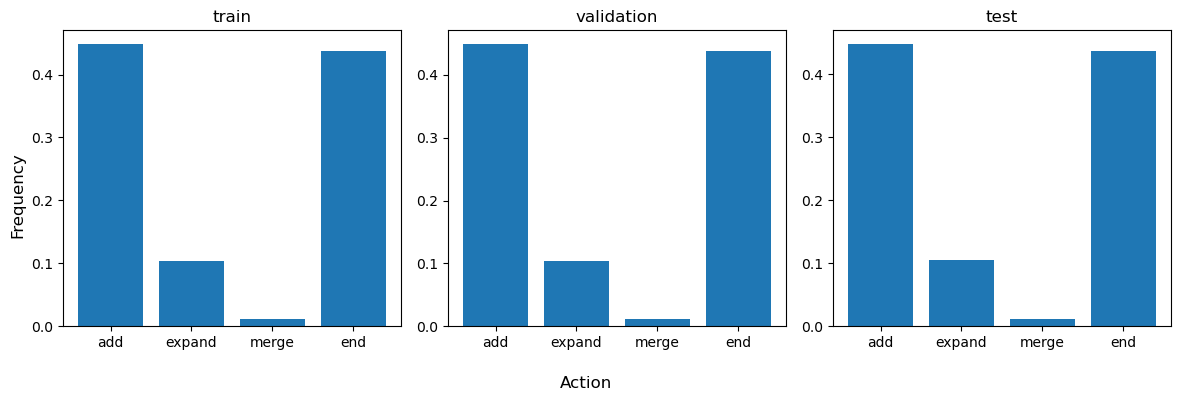

In [14]:
#Plot tree action frequency for each set 
fig, ax = plt.subplots(1,3, sharey = False, figsize=(12,4))

for i, trees in enumerate([train, valid, test]):
    actions = [tree['actions'] for tree in trees]
    actions = [act for group in actions for act in group]
    actions = pd.Series(actions)
    counts = actions.value_counts(normalize=True)
    ind = counts.index
    freq = counts.values
    ax[i].bar(ind, freq)
    ax[i].set_xticks(ticks=[0,1,2,3], labels=['add', 'expand', 'merge', 'end'])
    ax[i].set_title(names[i])

fig.supylabel('Frequency')
fig.supxlabel('Action')
fig.tight_layout()

We again observe the same distribution in all sets. Actions 1 and 2 have a joint frequency lower than 0.15, meaning that the majority of trees won't be branched 

Finally, we check root products (stored as SMILES in each tree). We use molar weight as an approximate measure of product complexity distribution, checking molar weight distribution for each set.

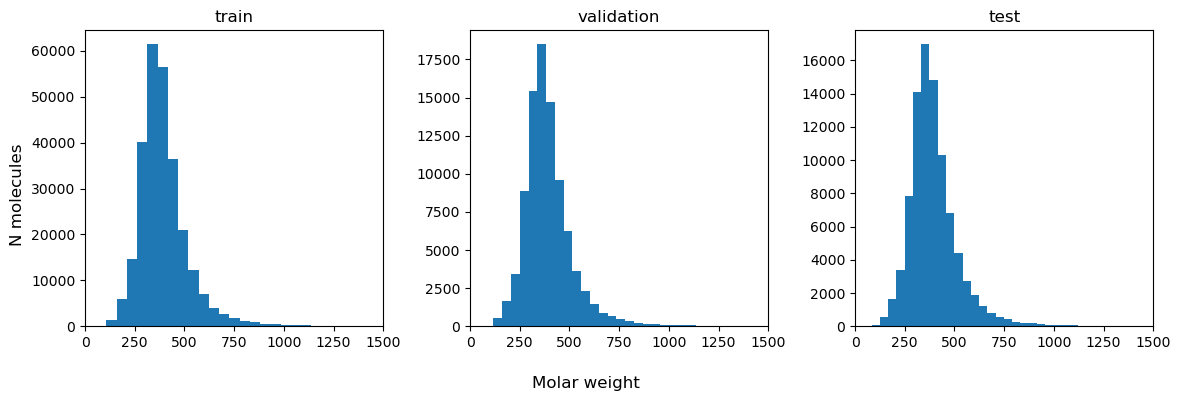

In [17]:
names = ['train', 'validation', 'test']

#Plot tree action frequency for each set 
fig, ax = plt.subplots(1,3, sharey = False, figsize=(12,4))

for i, trees in enumerate([train, valid, test]):
    smiles = [tree['root']['smiles'] for tree in trees]
    mw = [Descriptors.MolWt(Chem.MolFromSmiles(smile)) for smile in smiles]
    ax[i].hist(mw, bins=50)
    ax[i].set_xlim(0,1500)
    ax[i].set_title(names[i])

fig.supylabel('N molecules')
fig.supxlabel('Molar weight')
fig.tight_layout()

Molar weights are similarly distributed on the three sets, showing that the majority of root molecules have a value between 250 and 500.

The previous graphs show that synthetic tree data are similar for the three sets, and therefore we can conclude that all 

Finally, we extract 10000 SMILES corresponding to root molecules of trees from the test set. These molecules will be used as a 'reachable' molecules set to reproduce the original results of the paper and to also evaluate the trained models.

In [9]:
random.seed(42) 

smiles = [tree['root']['smiles'] for tree in random.sample(test, 10000)]

data = pd.Series(data=smiles, name='smiles')

data.to_csv('reachable_molecules.csv.gz', index=False)
